# Video Classification & Human Activity Recognition
Modified from the tutorial [Introduction to Video Classification & Human Activity Recognition](https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/)

**Here are the steps we will perform:**

- **Step 1: Download and Extract the Dataset**
- **Step 2: Visualize the Data with its Labels**
- **Step 3: Read and Preprocess the Dataset**
- **Step 4: Split the Data into Train and Test Set**
- **Step 5: Construct the Model**
- **Step 6: Compile & Train the Model**
- **Step 7: Plot Model’s Loss & Accuracy Curves**
- **Step 8: Make Predictions with the Model**
- **Step 9: Using Single-Frame CNN Method**

# **Import Required Libraries:**
Start by importing all required libraries.

In [2]:
import os
import cv2
import math
import shutil
# import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Directory where clips are stored for training
path = '/content/drive/MyDrive/help-cam-assets_shared'
data_directory = f'{path}/downloads/'

**Set Numpy, Python & Tensorflow seeds to get consistent results.**

In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **Visualize the Data with its Labels**
Pick some random videos from each class of the dataset and display it, this will give us a good overview of how the dataset look like.

In [ ]:
# ignore .DS_Store
def listVisibleFiles(directory):
    visible_files = []
    for file in os.listdir(directory):
        if not file.startswith('.'):
            visible_files.append(file)
            
    return visible_files

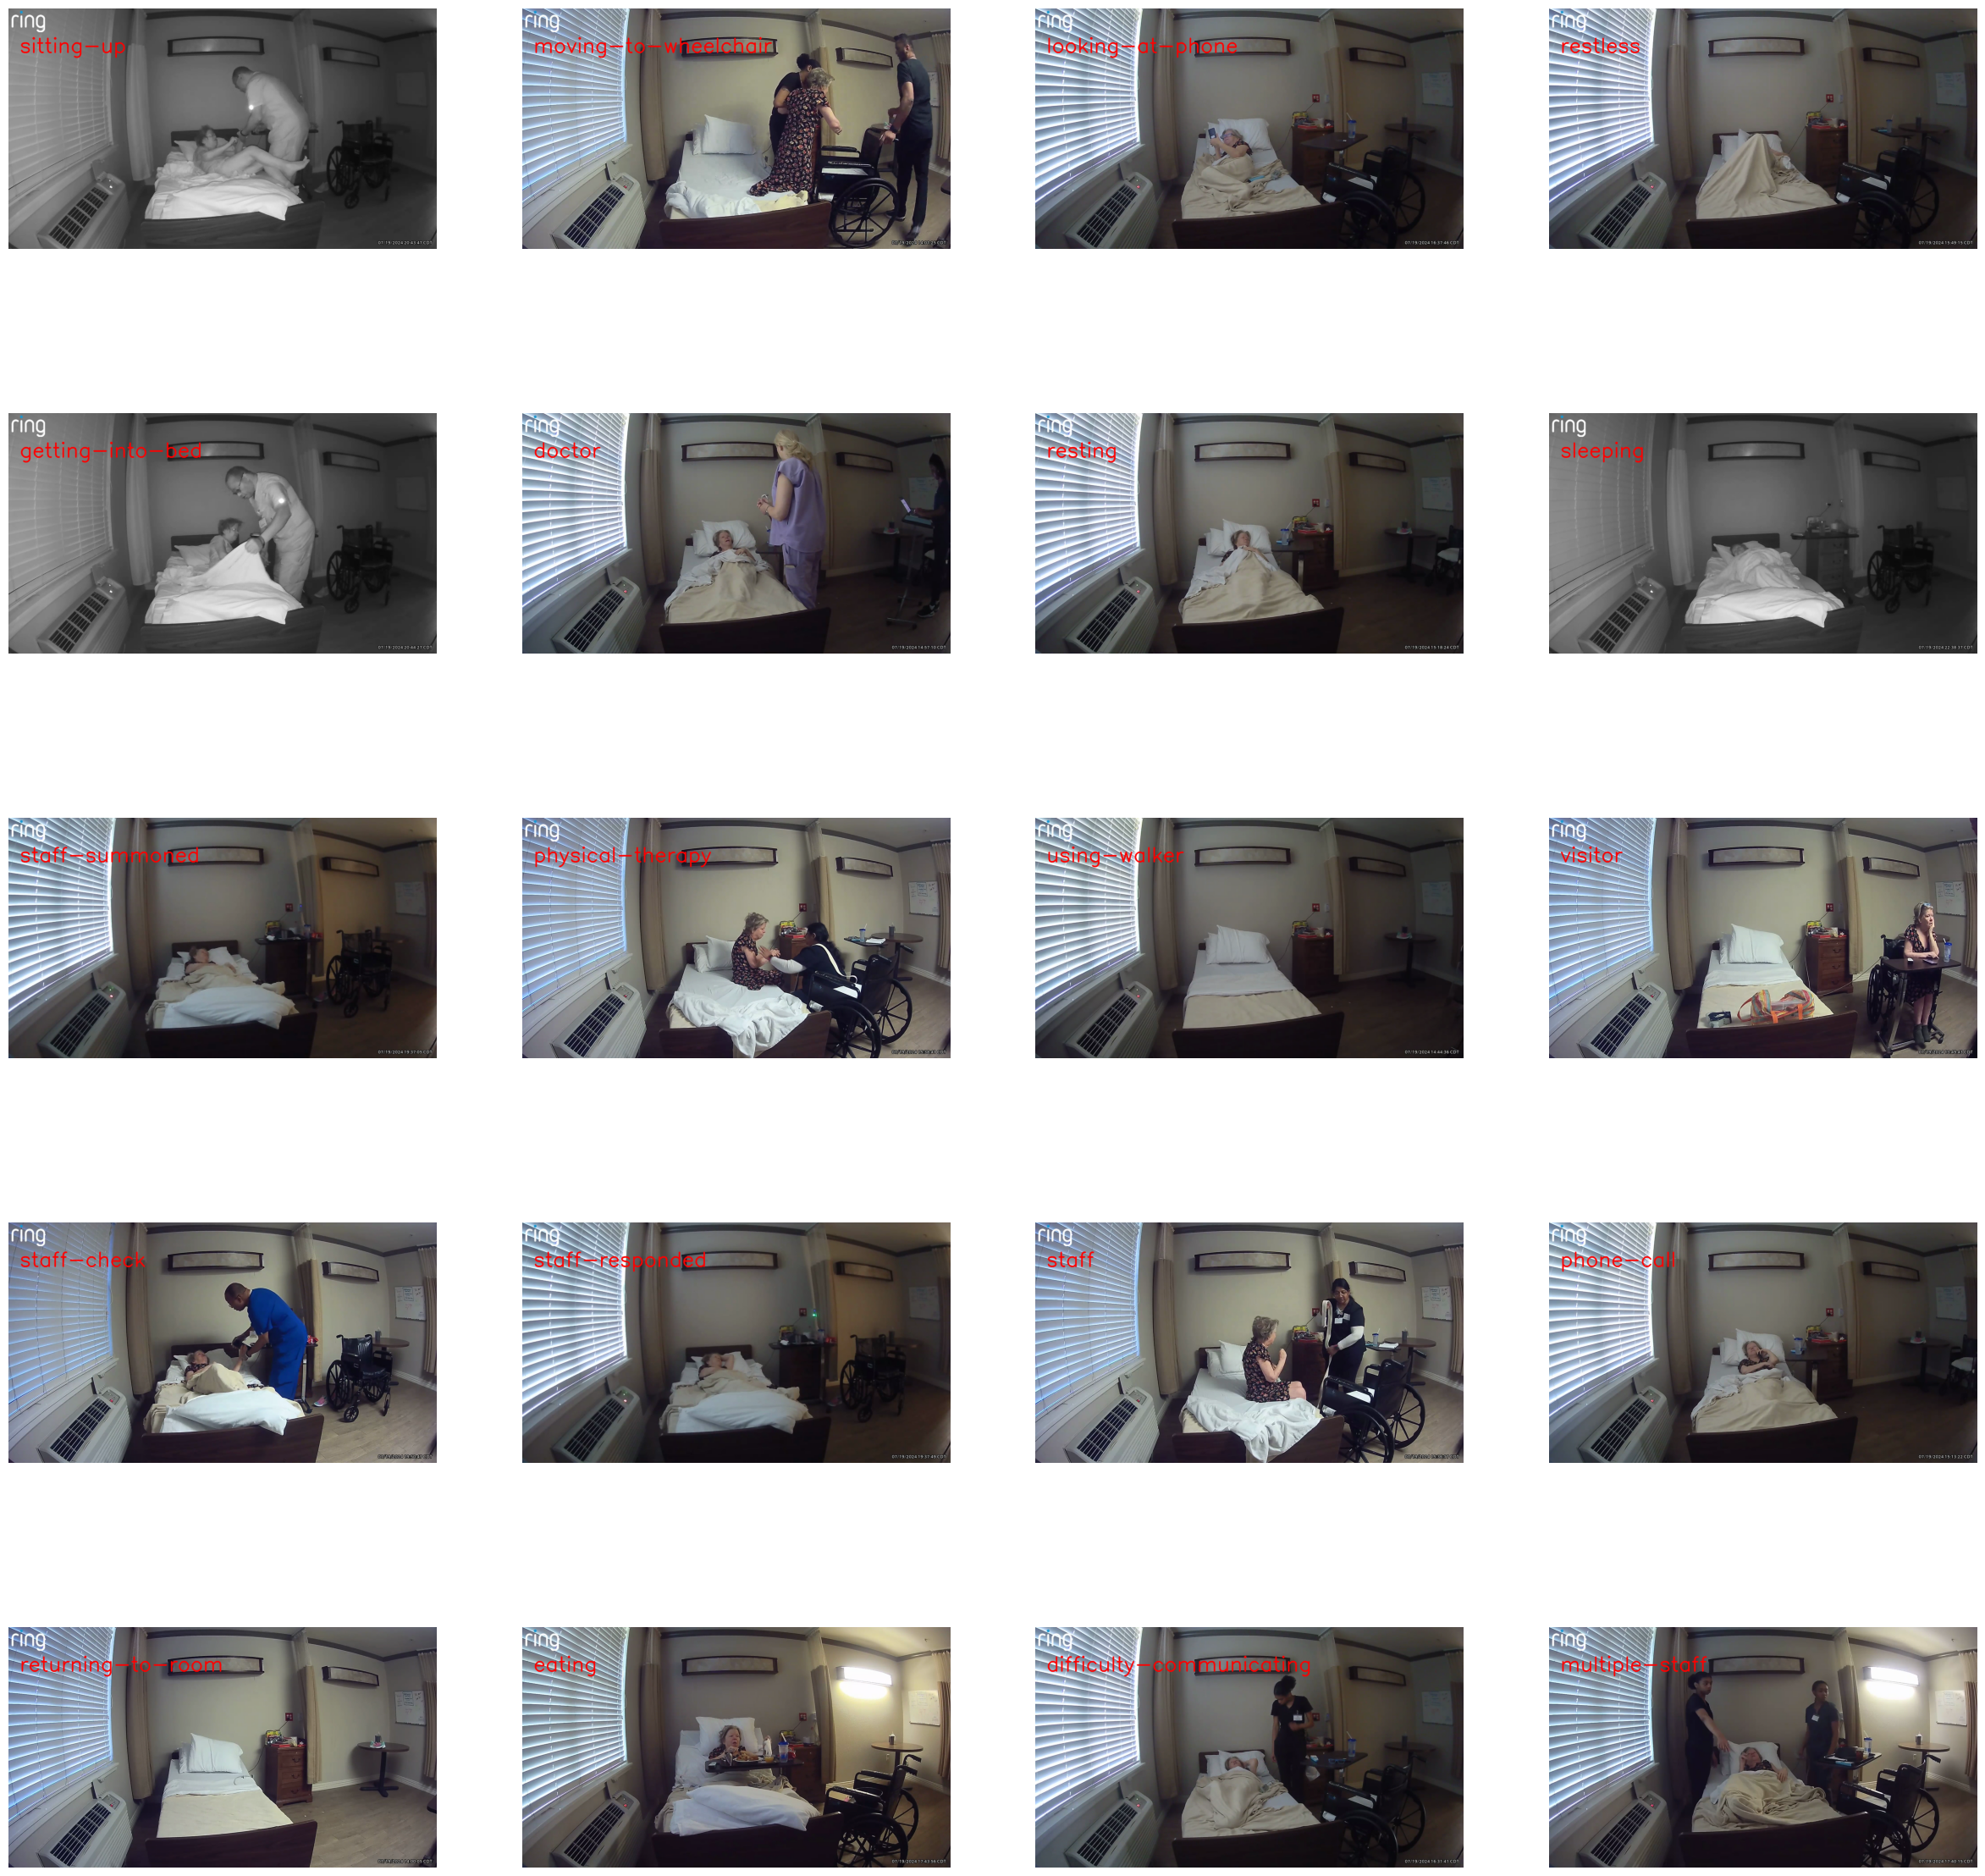

In [5]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = listVisibleFiles(data_directory)

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = listVisibleFiles(f'{data_directory}/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'{data_directory}/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

## **Step 3: Read & Preprocess the Dataset**

Since we're going to use a classification architecture to train on a video classification dataset, we're goiing to need to preprocess the dataset first.

Now w constants, 
- **`image_height`** and **`image_weight`**: This is the size we will resize all frames of the video to, we're doing this to avoid unneccsary computation.

- **`max_images_per_class`**: Maximum number of training images allowed for each class.

- **`dataset_directory`**: The path of the directory containing the extracted dataset. 

- **`classes_list`**: These are the list of classes we're going to be training on, we're traninng on following 4 classes, you can feel free to change it. 
  - *tai chi*
  - *Swinging*
  - *Horse Racing*
  - *Walking with a Dog*

**Note:** The `image_height`, `image_weight` and `max_images_per_class` constants may be increased for better results, but be warned this will become computationally expensive.

In [6]:
image_height, image_width = 64, 64
max_images_per_class = 8000

classes_list = []

labels = listVisibleFiles(data_directory)

for l in labels: 
    classes_list.append(l)

model_output_size = len(classes_list)
model_output_size

26

### **Extract, Resize & Normalize Frames**


Now we'll create a function that will extract frames from each video while performing other preprocessing operation like resizing and normalizing images. 

This method takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list and then finally returns that list.

In [7]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

### **Dataset Creation**
Now we'll create another function called  **`create_dataset()`**,  this function uses the **`frame_extraction()`** funciton above and creates our final preprocessed dataset. 

**Here's how this function works:**

1.   Iterate through all the classes mentioned in the `classes_list`
2.   Now for each class iterate through all the video files present in it. 
3.   Call the **frame_extraction** method on each video file.
4.   Add the returned frames to a list called `temp_features`
5.   After all videos of a class are processed, randomly select video frames (equal to **max_images_per_class**) and add them to the list called `features`.
6.   Add labels of the selected videos to the labels list.
7.   After all videos of all classes are processed then return the features and labels as numpy arrays.


So when you call this function, it returns **2** lists:
- a list of feature vectors 
- a list of it's associated labels.


In [8]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(data_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(data_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.choice(temp_features) for _ in range(max_images_per_class))  # changed to random.choice()

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

Calling the **create_dataset** method which returns features and labels.

In [9]:
features, labels = create_dataset()

Extracting Data of Class: housekeeping
Extracting Data of Class: watching-tv


OpenCV: Couldn't read video stream from file "data/watching-tv/.DS_Store"


Extracting Data of Class: difficulty-communicating
Extracting Data of Class: physical-therapy


OpenCV: Couldn't read video stream from file "data/physical-therapy/.DS_Store"


Extracting Data of Class: sleeping
Extracting Data of Class: returning-to-room


OpenCV: Couldn't read video stream from file "data/returning-to-room/.DS_Store"


Extracting Data of Class: doctor
Extracting Data of Class: looking-at-phone


OpenCV: Couldn't read video stream from file "data/looking-at-phone/.DS_Store"


Extracting Data of Class: sitting-up
Extracting Data of Class: getting-into-bed
Extracting Data of Class: multiple-staff
Extracting Data of Class: chris
Extracting Data of Class: staff-summoned
Extracting Data of Class: visitor
Extracting Data of Class: drinking
Extracting Data of Class: resting
Extracting Data of Class: restless
Extracting Data of Class: staff-check


OpenCV: Couldn't read video stream from file "data/staff-check/.DS_Store"


Extracting Data of Class: sitting-at-table


OpenCV: Couldn't read video stream from file "data/sitting-at-table/.DS_Store"


Extracting Data of Class: exiting-room
Extracting Data of Class: staff
Extracting Data of Class: moving-to-wheelchair
Extracting Data of Class: eating


OpenCV: Couldn't read video stream from file "data/eating/.DS_Store"


Extracting Data of Class: phone-call
Extracting Data of Class: staff-responded
Extracting Data of Class: using-walker


Now we will convert class labels to one hot encoded vectors.

In [10]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **Step 4: Split the Data into Train and Test Set**
Now we have 2 numpy arrays, one containing all images, the second one contains all class labels in one hot encoded format. Let’s split our data to create a training and a testing set. It’s important that you shuffle your data before the split which we have already done.


In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            one_hot_encoded_labels, 
                                                                            test_size = 0.2, 
                                                                            shuffle = True, 
                                                                            random_state = seed_constant)

## **Step 5: Construct the Model**
Now it’s time to create our CNN model, for this post, we're c reating a simple CNN Classification model with two CNN layers.

In [12]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,322 (247.35 KB)

 Trainable params: 62,682 (244.85 KB)

 Non-trainable params: 640 (2.50 KB)

Model Created Successfully!


### **Check Model’s Structure:**
Using the **plot_model** function you can check the structure of the final model, this is really helpful when you’re creating a complex network and you want to make sure you have constructed the network correctly.

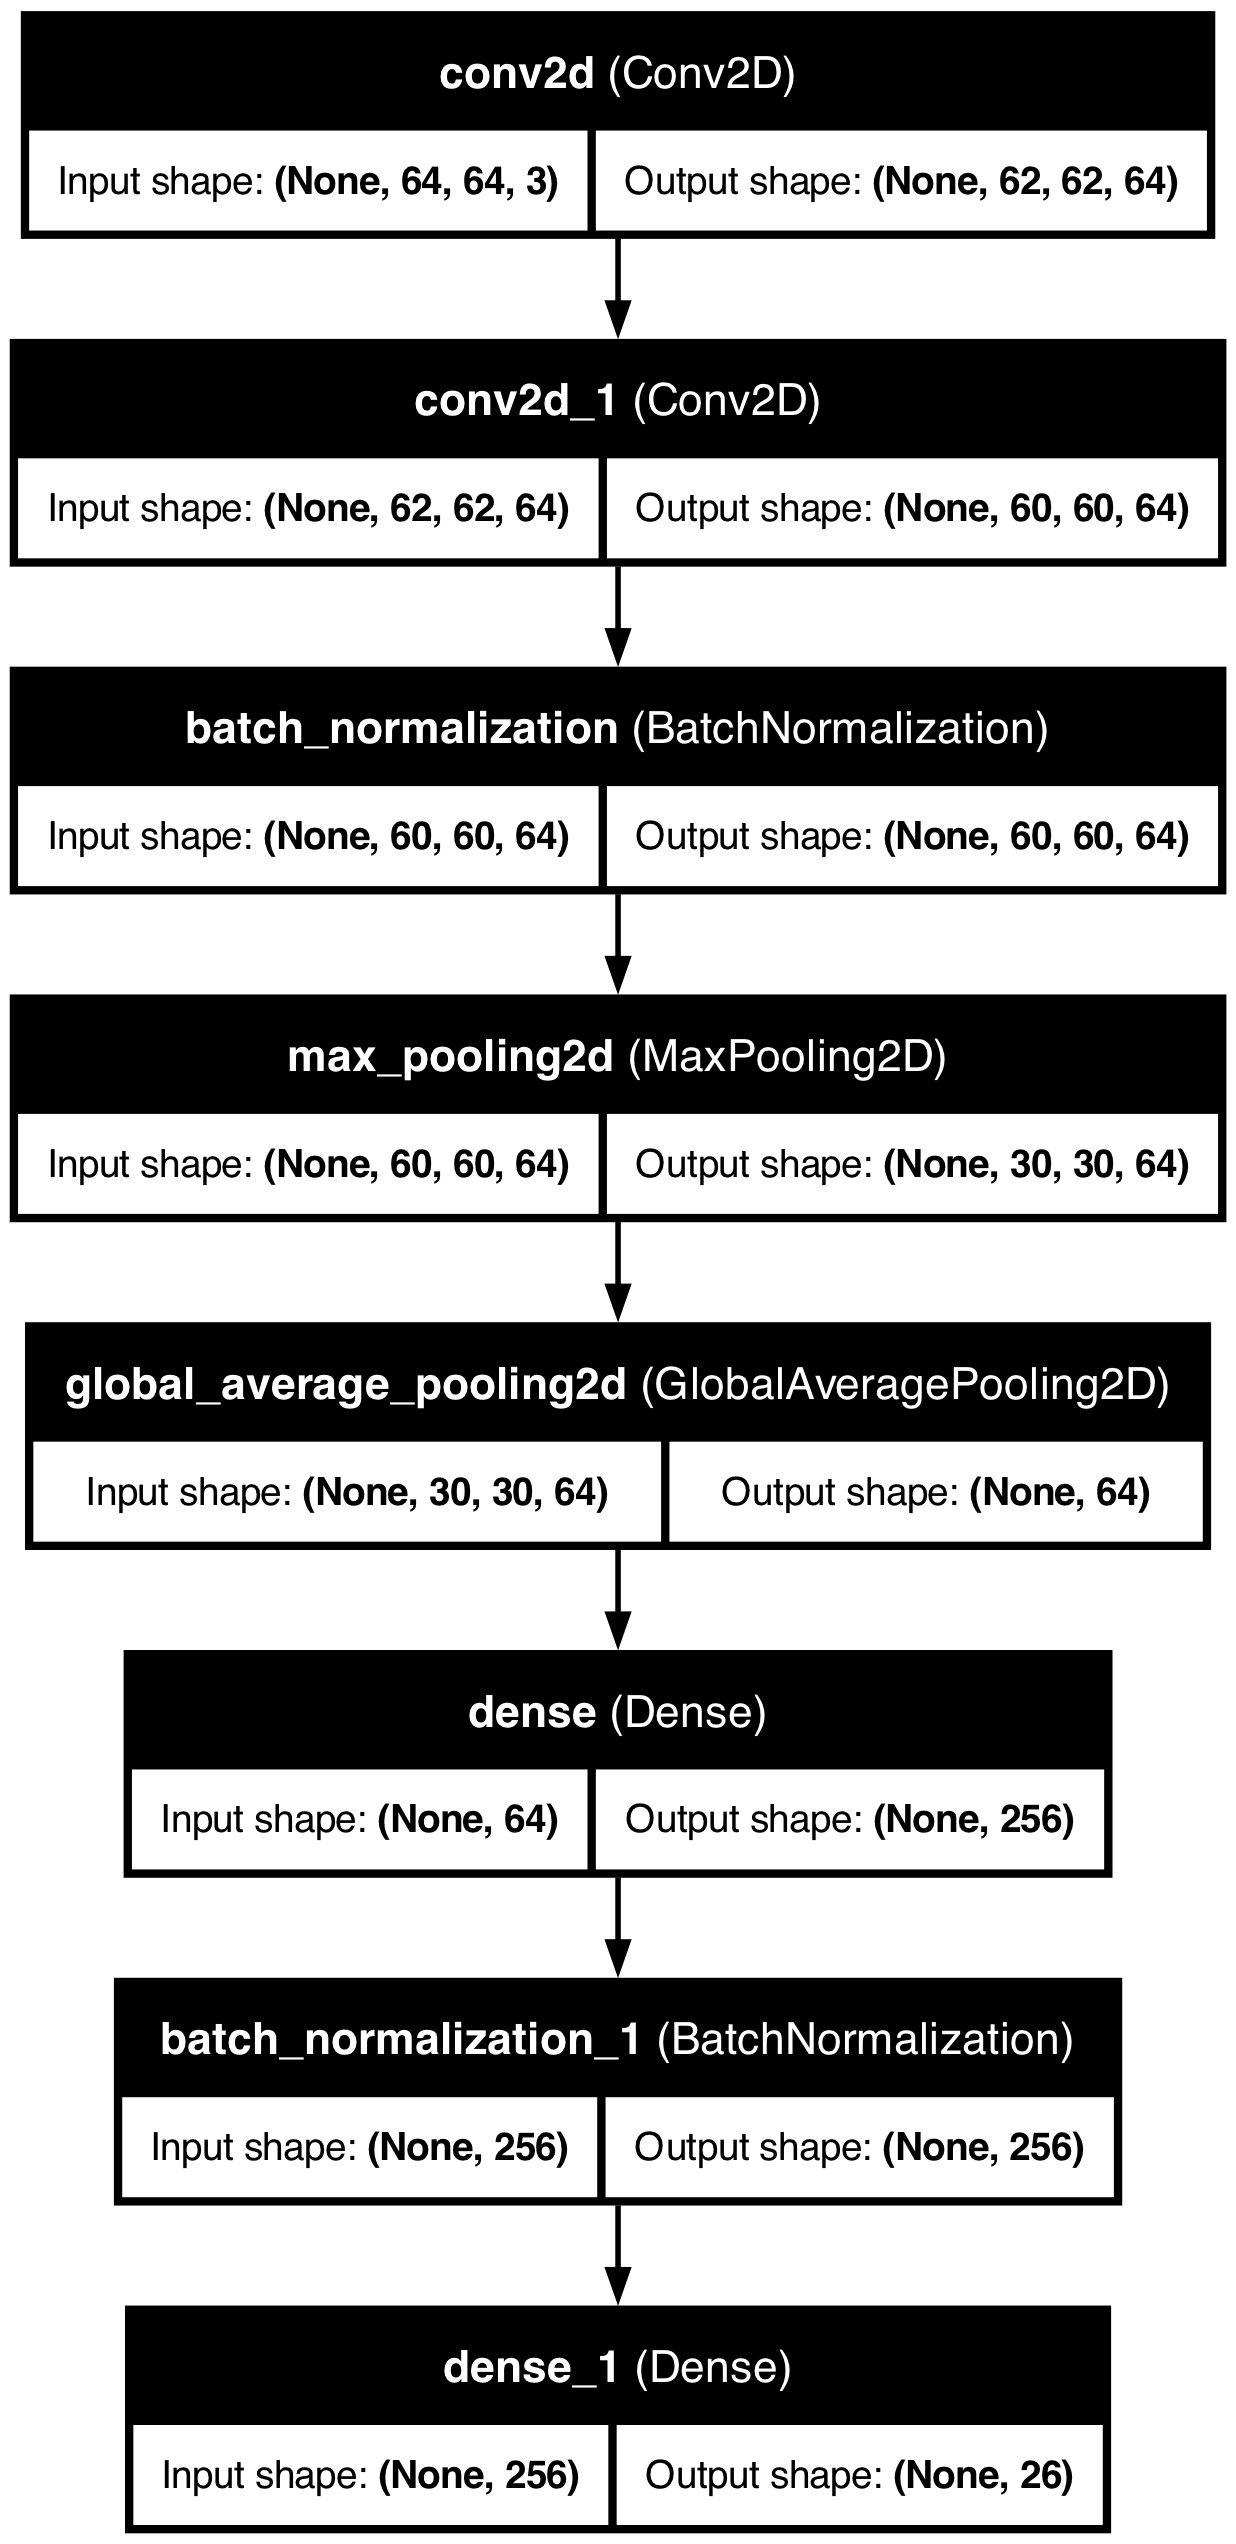

In [13]:
plot_model(model, to_file = 'model_structure_plot.png', 
           show_shapes = True, 
           show_layer_names = True)

## **Step 6: Compile & Train the Model**


Now let's start the training. Before we do that, we also need to complile the model.


In [14]:
# Adding the Early Stopping Callback to the model which will continuously monitor the validation loss metric for every epoch.
# If the models validation loss does not decrease after 15 consecutive epochs, the training will be stopped and the weight which reported the lowest validation loss will be retored in the model.
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'Adam', 
              metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, 
                                   y = labels_train, 
                                   epochs = 10, batch_size = 4, 
                                   shuffle = True, 
                                   verbose=1, 
                                   validation_split = 0.2)

Epoch 1/10
33280/33280 ━━━━━━━━━━━━━━━━━━━━ 767s 23ms/step - accuracy: 0.7659 - loss: 0.7393 - val_accuracy: 0.7053 - val_loss: 1.8314
Epoch 2/10
33280/33280 ━━━━━━━━━━━━━━━━━━━━ 745s 22ms/step - accuracy: 0.9741 - loss: 0.0811 - val_accuracy: 0.9971 - val_loss: 0.0301
Epoch 3/10
33280/33280 ━━━━━━━━━━━━━━━━━━━━ 775s 23ms/step - accuracy: 0.9848 - loss: 0.0509 - val_accuracy: 0.9968 - val_loss: 0.0539
Epoch 4/10
33280/33280 ━━━━━━━━━━━━━━━━━━━━ 768s 23ms/step - accuracy: 0.9876 - loss: 0.0410 - val_accuracy: 0.8704 - val_loss: 0.6571
Epoch 5/10
33280/33280 ━━━━━━━━━━━━━━━━━━━━ 755s 23ms/step - accuracy: 0.9894 - loss: 0.0341 - val_accuracy: 0.9943 - val_loss: 0.1677
Epoch 6/10
33280/33280 ━━━━━━━━━━━━━━━━━━━━ 751s 23ms/step - accuracy: 0.9907 - loss: 0.0326 - val_accuracy: 0.9877 - val_loss: 0.2453
Epoch 7/10
33280/33280 ━━━━━━━━━━━━━━━━━━━━ 739s 22ms/step - accuracy: 0.9918 - loss: 0.0288 - val_accuracy: 0.9969 - val_loss: 0.0198
Epoch 8/10
33280/33280 ━━━━━━━━━━━━━━━━━━━━ 755s 23ms/s

### **Evaluating Your Trained Model**
Evaluate your trained model on the feature's and label's test sets.

In [15]:
model_evaluation_history = model.evaluate(features_test, labels_test)

1300/1300 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - accuracy: 0.9976 - loss: 0.0448


### **Save Your Model**
You should now save your model for future runs.

In [16]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

In [ ]:
# Move saved model to Google Drive
colab_root = './'
files_root = listVisibleFiles(colab_root)

for file in files_root:
  file_name = model_name
  default_path = f'{colab_root}/{model_name}'
  moved_path = f"{path}/Code and models/Trained models/{file_name}"

  if file == model_name:
    # moved_files = listVisibleFiles(moved_path)
    print(f"Moving {file}")
    shutil.move(default_path, moved_path)

print("Done")

## **Step 7: Plot Model’s Loss & Accuracy Curves**
Let's plot our loss and accuracy curves.

In [17]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

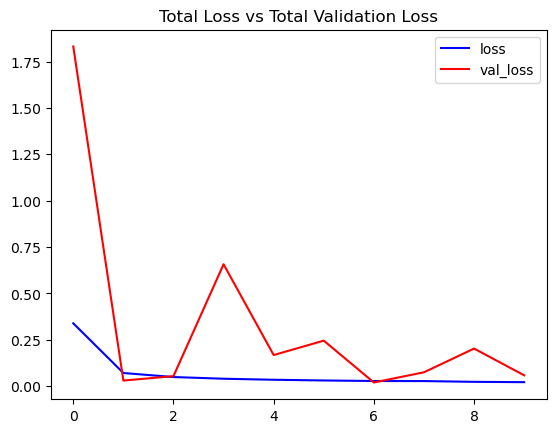

In [18]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

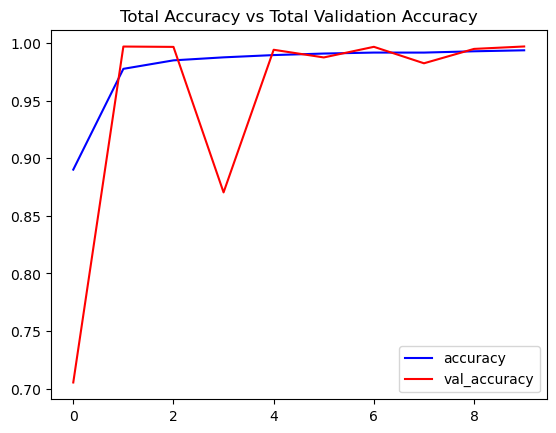

In [19]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **Step 8: Make Predictions with the Model:**
Now that we have created and trained our model it's time to test it's performance on some test videos.


#### **Function To Predict on Live Videos Using Moving Average:**
This function will predict on live videos using moving_average, you can either pass in videos saved on disk or use your webcam. If you set `window_size` hyperparameter to `1` then this function will behave like a normal classifier to predict on video frames.

**Note:** *You can't use your webcam if you're running this notebook on google colab.*

In [20]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

#### **Download a Test Video:**

#### **Results Without Using Moving Average:**
First let's see the results when we're not using moving average, we can do this by setting the `window_size` to `1`.

In [25]:
# Setting sthe Widow Size which will be used by the Rolling Averge Proces
window_size = 1

# Construting The Output Video Path
input_video_file_path = './test/Ring_Cindy_20240720_1917.mp4'  # change path
output_video_file_path = './predictions/prediction3.mp4'  # change path


# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
#VideoFileClip(output_video_file_path)  # uncomment if running this function

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

#### **Results When Using Moving Average:**
Now let's use moving average with a window size of `25`.

In [27]:
# Setting the Widow Size which will be used by the Rolling Averge Process
window_size = 25

# Construting The Output Video Path
output_directory = './predictions/'  # make sure path is correct
video_title = 'prediction4'  # change output file name if needed
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction and Rolling Averge Process
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# # Play Video File in the Notebook
# VideoFileClip(output_video_file_path).ipython_display(width = 700)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━

Although the results, are not perfect but you can clearly see that it's much better than the previous approach of predicting on each frame independently.

## **Step 9: Using Single-Frame CNN Method:**
Now let's create a function that will output a singular prediction for the complete video, now this function will take `n` frames from the entire video and make predictions. In the end, it will average the predictions of those <code>n</code> frames to give you the final activity class for that video. You can set the value of <code>n</code> using the <code>predictions_frames_count</code> variable.

This function is useful when you have a video containing one activity and you want to know the activity's name and its score.


In [85]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    top_predictions = []

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]
        predicted_probability = round(predicted_probability*100, 2)

        top_predictions.append([predicted_class_name, predicted_probability])

        # print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {predicted_probability}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()

    return top_predictions

#### **Test Average Prediction Method 

In [103]:
# Change file name if needed
video_title = "prediction6.mp4"  

# Construting The Input path
input_video_file_path = './test/Ring_Cindy_20240720_1932.mp4'

# Calling The Make Average Method To Start The Process
avg_pred = make_average_predictions(input_video_file_path, 50)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [104]:
# Print predictions and probabilities
for p in avg_pred:
    print(p)

['drinking', 24.51]
['staff-check', 17.88]
['multiple-staff', 16.4]
['phone-call', 8.04]
['moving-to-wheelchair', 7.67]
['exiting-room', 7.49]
['physical-therapy', 7.1]
['using-walker', 6.47]
['staff', 1.93]
['chris', 1.18]
['returning-to-room', 0.92]
['staff-responded', 0.19]
['visitor', 0.1]
['restless', 0.07]
['getting-into-bed', 0.02]
['resting', 0.01]
['sitting-at-table', 0.0]
['eating', 0.0]
['sleeping', 0.0]
['looking-at-phone', 0.0]
['housekeeping', 0.0]
['staff-summoned', 0.0]
['watching-tv', 0.0]
['doctor', 0.0]
['sitting-up', 0.0]
['difficulty-communicating', 0.0]


In [105]:
probs = []
for n in avg_pred:
    prob = n[1]
    probs.append(prob)
print([probs])

[[24.51, 17.88, 16.4, 8.04, 7.67, 7.49, 7.1, 6.47, 1.93, 1.18, 0.92, 0.19, 0.1, 0.07, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


## Make DataFrame of probabilities, sort by top probability

In [106]:
#Make DataFrame
df = pd.DataFrame(avg_pred)

# Sort by top probability
df = df.sort_values(by=[1], ascending=False)
df

0      1
0                   drinking  24.51
1                staff-check  17.88
2             multiple-staff  16.40
3                 phone-call   8.04
4       moving-to-wheelchair   7.67
5               exiting-room   7.49
6           physical-therapy   7.10
7               using-walker   6.47
8                      staff   1.93
9                      chris   1.18
10         returning-to-room   0.92
11           staff-responded   0.19
12                   visitor   0.10
13                  restless   0.07
14          getting-into-bed   0.02
15                   resting   0.01
16          sitting-at-table   0.00
17                    eating   0.00
18                  sleeping   0.00
19          looking-at-phone   0.00
20              housekeeping   0.00
21            staff-summoned   0.00
22               watching-tv   0.00
23                    doctor   0.00
24                sitting-up   0.00
25  difficulty-communicating   0.00

In [102]:
# Print top 3
top_three = df.head()[:3]
top_three

0      1
0  multiple-staff  55.98
1         resting  23.17
2    using-walker  11.11